## Вступление

**Контекст**

*Deskdrop* - это платформа для внутренней коммуникации, разработанная компанией CI&T, ориентированная на компании, использующие Google G Suite. Среди других функций, эта платформа позволяет сотрудникам компаний делиться релевантными статьями с коллегами и сотрудничать вокруг них.

**Содержание**

Этот богатый и редкий набор данных содержит реальный образец логов за 12 месяцев (март 2016 - февраль 2017) с платформы внутренней коммуникации CI&T (DeskDrop).
Он содержит около 73 000 зарегистрированных взаимодействий пользователей с более чем 3000 публичных статей, размещенных на платформе.

Этот набор данных имеет ряд отличительных особенностей:

* Атрибуты элементов: Оригинальный URL, заголовок и текст статей доступны на двух языках (английском и португальском).

* Контекстная информация: Контекст посещений пользователей, такой как дата/время, клиент (нативное мобильное приложение / браузер) и геолокация.

* Зарегистрированные пользователи: Все пользователи должны войти в систему на платформе, что обеспечивает долгосрочное отслеживание предпочтений пользователей (не зависящее от файлов cookie в устройствах).

* Богатая неявная обратная связь: Были зарегистрированы различные типы взаимодействий, что позволяет сделать вывод об уровне интереса пользователя к статьям (например, комментарии > лайки > просмотры).

* Многоплатформенность: Взаимодействия пользователей отслеживались на разных платформах (веб-браузеры и нативные мобильные приложения)

In [166]:
!pip install implicit

In [167]:
IS_COLAB = True
if IS_COLAB:
    from google.colab import drive
    drive.mount('/drive')
    path = '/drive/MyDrive/Analytics/DeskDrop_RecSys/'

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [168]:
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import scipy.sparse as sp

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import implicit
from implicit.als import AlternatingLeastSquares
from tqdm.notebook import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

### User Interactions

In [169]:
interactions = pd.read_csv(path + 'users_interactions.csv')
interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [170]:
interactions['date_time'] = pd.to_datetime(interactions['timestamp'], unit='s')
interactions = interactions.drop('timestamp', axis=1)
interactions.head()

,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,date_time
0,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,2016-06-08 19:10:32
1,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,2016-06-08 19:02:40
2,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,2016-06-08 20:03:10
3,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,2016-06-08 19:24:55
4,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,2016-06-08 18:58:10


In [171]:
print('Shape:', interactions.shape)
print()
print('Types:')
print(interactions.dtypes)
print()
print('NaN:')
print(interactions.isnull().sum())
print()
print('Duplicates:')
print(interactions.duplicated().sum())

Shape: (72312, 8)

Types:
eventType              object
contentId               int64
personId                int64
sessionId               int64
userAgent              object
userRegion             object
userCountry            object
date_time      datetime64[ns]
dtype: object

NaN:
eventType          0
contentId          0
personId           0
sessionId          0
userAgent      15394
userRegion     15405
userCountry    15394
date_time          0
dtype: int64

Duplicates:
11


In [172]:
interactions = interactions.drop_duplicates()
interactions = interactions.fillna('Not Stated')
interactions = interactions.replace('?', 'Not Stated')

In [173]:
interactions['date_time'].describe()

,date_time
count,72301
mean,2016-08-02 01:50:08.084217344
min,2016-03-14 13:54:36
25%,2016-06-02 13:59:23
50%,2016-07-12 16:55:58
75%,2016-09-21 12:35:57
max,2017-02-28 19:21:51


In [174]:
event_type_count = interactions \
    .groupby(['eventType'])['eventType'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
event_type_count

,eventType,count
0,VIEW,61075
1,LIKE,5745
2,BOOKMARK,2463
3,COMMENT CREATED,1611
4,FOLLOW,1407


In [175]:
print('Unique Users:', interactions['personId'].nunique())
print('Unique Contents:', interactions['contentId'].nunique())
print('Unique Sessions:', interactions['sessionId'].nunique())

Unique Users: 1895
Unique Contents: 2987
Unique Sessions: 28740


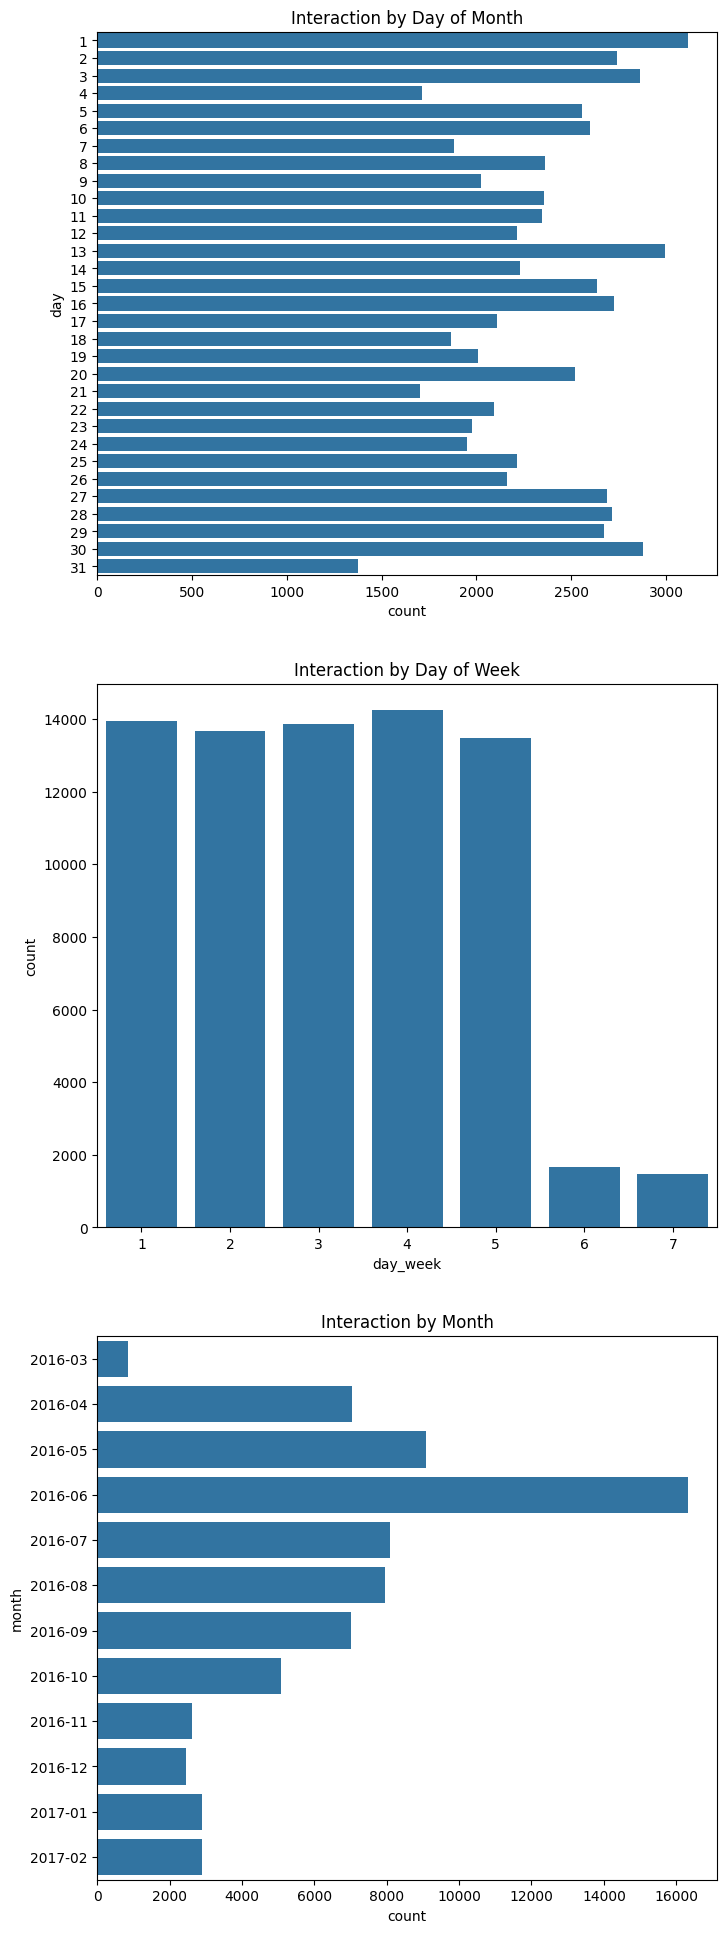

In [176]:
date_df = pd.DataFrame({
    'day': interactions['date_time'].dt.day,
    'day_week': interactions['date_time'].dt.dayofweek + 1,
    'month': interactions['date_time'].dt.to_period('M'),
})

day_count = date_df.groupby('day', as_index=False)['day'].value_counts()
week_count = date_df.groupby('day_week', as_index=False)['day_week'].value_counts()
month_count = date_df.groupby('month', as_index=False)['month'].value_counts()

fig, ax = plt.subplots(3, 1, figsize=(8,24))

sns.barplot(day_count, y='day', x='count', orient="y", ax=ax[0])
ax[0].set_title('Interaction by Day of Month')

sns.barplot(week_count, x='day_week', y='count', ax=ax[1])
ax[1].set_title('Interaction by Day of Week')

sns.barplot(month_count, y='month', x='count', orient="y", ax=ax[2])
ax[2].set_title('Interaction by Month')

plt.show()

In [177]:
agent_count = interactions \
    .groupby(['userAgent'])['userAgent'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
agent_count.head(10)

,userAgent,count
0,Not Stated,15394
1,Android - Native Mobile App,6751
2,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,1823
3,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,1146
4,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,1076
5,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,1059
6,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,1011
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,885
8,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,859
9,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,844


In [178]:
region_count = interactions \
    .groupby(['userRegion'])['userRegion'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
region_count.head(10)

,userRegion,count
0,SP,40156
1,Not Stated,15732
2,MG,10228
3,NY,1257
4,TX,922
5,GA,910
6,RJ,775
7,NJ,698
8,CA,238
9,ON,202


In [179]:
country_count = interactions \
    .groupby(['userCountry'])['userCountry'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
country_count.head(10)

,userCountry,count
0,BR,51387
1,Not Stated,15394
2,US,4656
3,KR,239
4,CA,226
5,JP,143
6,AU,138
7,GB,22
8,DE,19
9,IE,14


In [180]:
person_content = interactions.groupby('personId', as_index=True)['contentId'] \
            .count().describe([.025, .05, .25, .5, .75, .95, .975]).to_frame()
content_session = interactions.groupby('contentId', as_index=True)['sessionId'] \
            .count().describe([.025, .05, .25, .5, .75, .95, .975]).to_frame()
person_content.join(content_session)

,contentId,sessionId
count,1895.000000,2987.000000
mean,38.153562,24.205223
std,104.127329,32.447305
min,1.000000,1.000000
2.5%,1.000000,1.000000
5%,1.000000,1.000000
25%,3.000000,6.000000
50%,10.000000,14.000000
75%,32.000000,30.000000
95%,155.600000,80.000000


### Shared Articles

In [181]:
articles = pd.read_csv(path + 'shared_articles.csv')
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [182]:
articles['date_time'] = pd.to_datetime(articles['timestamp'], unit='s')
articles = articles.drop('timestamp', axis=1)
articles.head()

,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,date_time
0,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,2016-03-28 19:19:39
1,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,2016-03-28 19:39:48
2,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,2016-03-28 19:42:26
3,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,2016-03-28 19:47:54
4,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,2016-03-28 19:48:17


In [183]:
print('Shape:', articles.shape)
print()
print('Types:')
print(articles.dtypes)
print()
print('NaN:')
print(articles.isnull().sum())
print()
print('Duplicates:')
print(articles.duplicated().sum())

Shape: (3122, 13)

Types:
eventType                  object
contentId                   int64
authorPersonId              int64
authorSessionId             int64
authorUserAgent            object
authorRegion               object
authorCountry              object
contentType                object
url                        object
title                      object
text                       object
lang                       object
date_time          datetime64[ns]
dtype: object

NaN:
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
date_time             0
dtype: int64

Duplicates:
0


In [184]:
articles['date_time'].describe()

,date_time
count,3122
mean,2016-07-18 01:01:25.566944256
min,2016-03-28 19:19:39
25%,2016-05-04 13:36:26.500000
50%,2016-06-28 17:42:13
75%,2016-09-14 17:15:51
max,2017-02-28 18:51:11


In [185]:
articles = articles.fillna('Not Stated')

print('Unique Authors:', articles['authorPersonId'].nunique())
print('Unique Contents:', articles['contentId'].nunique())
print('Unique Sessions:', articles['authorSessionId'].nunique())

Unique Authors: 252
Unique Contents: 3057
Unique Sessions: 2017


In [186]:
event_type_count = articles \
    .groupby(['eventType'])['eventType'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
event_type_count

,eventType,count
0,CONTENT SHARED,3047
1,CONTENT REMOVED,75


In [187]:
content_type_count = articles \
    .groupby(['contentType'])['contentType'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
content_type_count

,contentType,count
0,HTML,3101
1,VIDEO,11
2,RICH,10


In [188]:
language_count = articles \
    .groupby(['lang'])['lang'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
language_count

,lang,count
0,en,2264
1,pt,850
2,la,4
3,es,2
4,ja,2


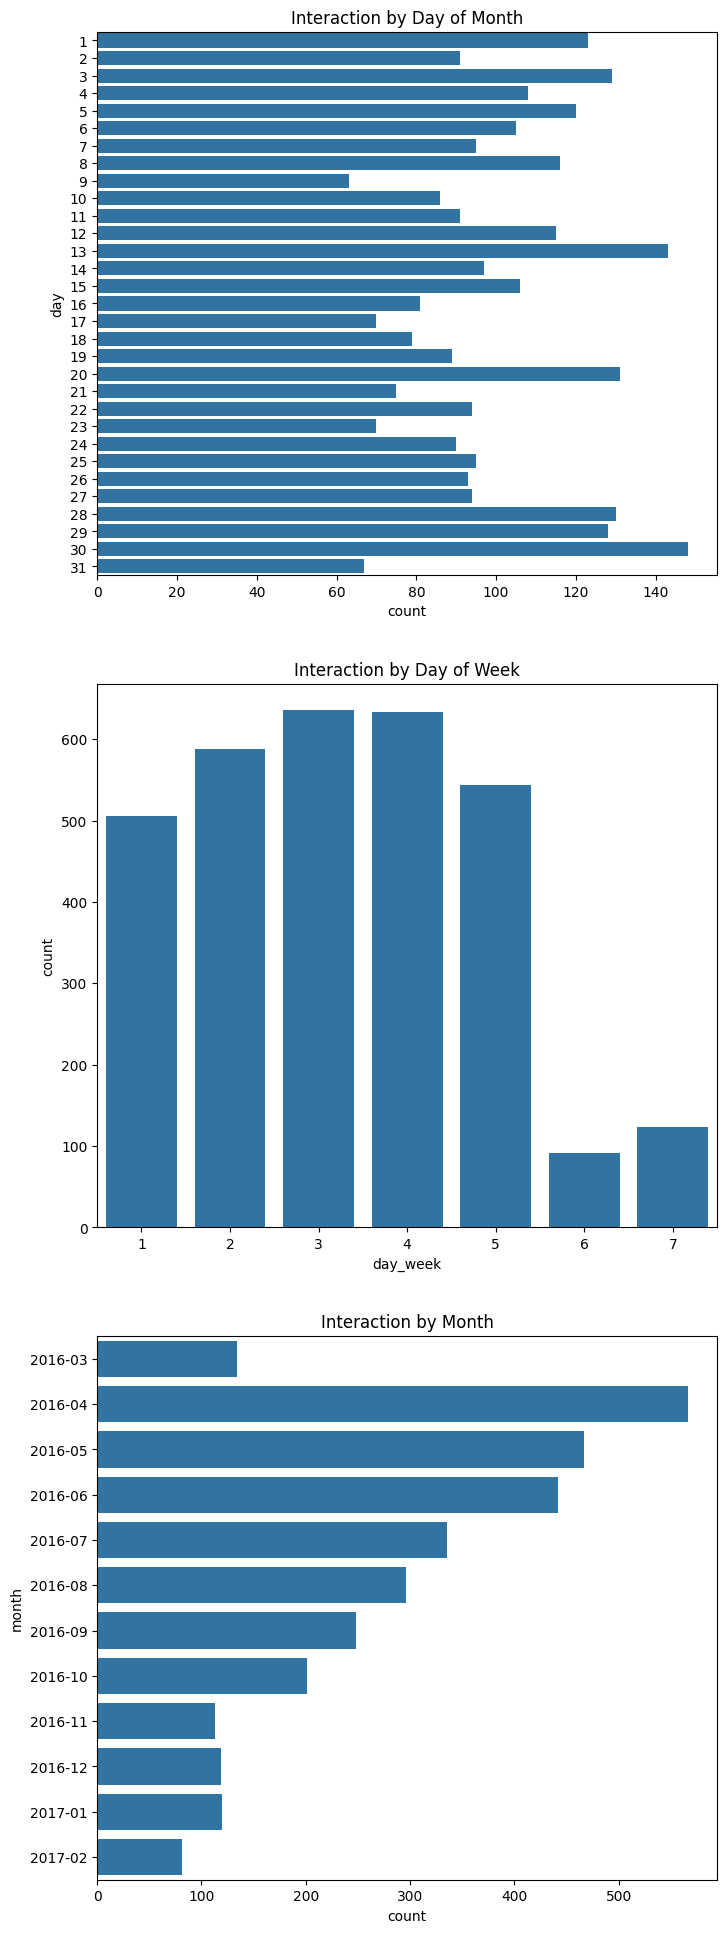

In [189]:
date_df = pd.DataFrame({
    'day': articles['date_time'].dt.day,
    'day_week': articles['date_time'].dt.dayofweek + 1,
    'month': articles['date_time'].dt.to_period('M'),
})

day_count = date_df.groupby('day', as_index=False)['day'].value_counts()
week_count = date_df.groupby('day_week', as_index=False)['day_week'].value_counts()
month_count = date_df.groupby('month', as_index=False)['month'].value_counts()

fig, ax = plt.subplots(3, 1, figsize=(8,24))

sns.barplot(day_count, y='day', x='count', orient="y", ax=ax[0])
ax[0].set_title('Interaction by Day of Month')

sns.barplot(week_count, x='day_week', y='count', ax=ax[1])
ax[1].set_title('Interaction by Day of Week')

sns.barplot(month_count, y='month', x='count', orient="y", ax=ax[2])
ax[2].set_title('Interaction by Month')

plt.show()

In [190]:
articles['url_domain'] = articles['url'] \
    .apply(lambda x: re.sub(r'^http[s]*:\/\/', '',
                            re.search(r'^http[s]*:\/\/[\w\.]*',
                                      x, re.IGNORECASE).group(0)))

url_count = articles \
    .groupby(['url_domain'])['url_domain'] \
    .value_counts().sort_values(ascending=False) \
    .reset_index()
url_count.head(10)

,url_domain,count
0,techcrunch.com,190
1,medium.com,132
2,cloudplatform.googleblog.com,72
3,startupi.com.br,50
4,www.imdb.com,49
5,exame.abril.com.br,45
6,googlediscovery.com,43
7,www.mckinsey.com,41
8,www.businessinsider.com,38
9,www.wired.com,35


## Подготовка данных

Для каждого типа фидбека добавим веса. Далее мы преобразуем это в рейтинг.

In [191]:
event_type_strength = {
    'VIEW': 1.0,
    'LIKE': 4.0,
    'BOOKMARK': 5.0,
    'COMMENT CREATED': 6.0,
    'FOLLOW': 7.0
}

interactions['rating'] = interactions['eventType'] \
    .apply(lambda x: event_type_strength[x])
interactions.head()

,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,date_time,rating
0,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,Not Stated,Not Stated,Not Stated,2016-06-08 19:10:32,1.0
1,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,2016-06-08 19:02:40,1.0
2,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,Not Stated,Not Stated,Not Stated,2016-06-08 20:03:10,1.0
3,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,Not Stated,Not Stated,Not Stated,2016-06-08 19:24:55,7.0
4,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,Not Stated,Not Stated,Not Stated,2016-06-08 18:58:10,1.0


У RecSys есть проблема user cold-start. Поэтому будем обучать модели на датасете, где пользователи взаимодействовали, как минимум с 5 различными статьями.

In [192]:
ENOUGH_USERS = 5
TRAIN_SIZE = 0.8
RANDOM_STATE = 123

np.random.seed(RANDOM_STATE)

In [193]:
users_interations = interactions \
    .groupby(['personId', 'contentId'], as_index=False) \
    [['personId', 'contentId']].value_counts() \
    .groupby('personId', as_index=False) \
    ['personId'].value_counts()

users_enough_interations = users_interations[users_interations['count'] >= ENOUGH_USERS]
len(users_enough_interations)

1140

Просуммируем каждый тип фидбека и добавим сглаживание рейтинга с помощью функции $ \sqrt{x}$.

In [194]:
full_interactions = interactions.merge(
    users_enough_interations,
    how='inner', on='personId'
)

full_interactions = full_interactions \
    .groupby(['personId', 'contentId']) \
    ['rating'].sum() \
    .apply(lambda x: np.sqrt(x)) \
    .reset_index()

print(len(full_interactions))
full_interactions.head(10)

39106


,personId,contentId,rating
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,2.828427
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.414214


In [195]:
train_interactions, test_interactions = train_test_split(
    full_interactions,
    stratify=full_interactions['personId'],
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

full_idx_interactions = full_interactions.set_index('personId')
train_idx_interactions = train_interactions.set_index('personId')
test_idx_interactions = test_interactions.set_index('personId')

print('Train Set Size:', len(train_interactions))
print('Test Set Size:', len(test_interactions))

Train Set Size: 31284
Test Set Size: 7822


## Evaluation

Top-N accuracy метрики: **Recall@N** и **MAP@N**.

In [196]:
MAX_NON_INTERACTED_ITEMS = 100
MAX_TOP_N = 10 ** 9
MAX_MOD = 1e9 + 7

NUM_FACTORS = 15

In [197]:
def MAP_k(true_items, pred_items, k=10):
    if not true_items.all():
        return 0.0
    if len(pred_items) > k:
        pred_items = pred_items[:k]
    map_k = 0.0
    num_hits = 0.0
    for i, item in enumerate(pred_items):
        if item in true_items and item not in pred_items[:i]:
            num_hits += 1.0
            map_k += num_hits / (i + 1.0)
    map_k /= min(len(true_items), k)
    return map_k

In [198]:
def get_interacted_items(user_id, user_item_data):
    interacted_items = user_item_data.loc[user_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series
                                else [interacted_items])
def print_metrics(metrics):
    print(f'model_name:\t {metrics["model_name"]}')
    print(f'recall@k:\t {metrics["recall@k"]}')
    print(f'MAP@k:\t\t {metrics["MAP@k"]}')

In [199]:
class Evaluator:
    def get_not_interacted_items_sample(self, user_id, sample_size,
                                        random_seed=RANDOM_STATE):
        interacted_items = get_interacted_items(user_id, full_idx_interactions)
        all_items = set(articles['contentId'])
        non_iteracted_items = all_items - interacted_items
        return set(random.sample(non_iteracted_items, sample_size))

    def verify_hit_top_n(self, item_id, recommended_items, top_n):
        try:
            index = next(i for i, item in enumerate(recommended_items) \
                         if item == item_id)
        except:
            index = -1
        hit = int(index in range(top_n))
        return hit, index

    def evaluate_for_user(self, model, user_id, k):
        # Все items для юзера
        test_interacted_items = test_idx_interactions.loc[user_id]
        user_test_interacted_items = set(
            test_interacted_items['contentId'] \
            if type(test_interacted_items['contentId']) == pd.Series \
            else [int(test_interacted_items['contentId'])]
        )
        test_interacted_items_count = len(user_test_interacted_items)
        #Для юзера получаем список ранжированных рекоммендаций
        user_recs = model.recommend_items(
            user_id, ignore_items=get_interacted_items(
                user_id, train_idx_interactions), top_n=MAX_TOP_N
        )
        hits_k = 0
        #Для каждого item, с которым юзер взаимодействовал в test set
        for item_id in user_test_interacted_items:
            #Получаем случайную выборку (100) items, с которыми юзер не взаимодействовал
            non_interacted_items_smaple = self.get_not_interacted_items_sample(
                user_id, MAX_NON_INTERACTED_ITEMS, item_id % MAX_MOD
            )
            filter_items_recs = non_interacted_items_smaple.union(set([item_id]))
            #Отбираем либо только те item'ы, которые находятся в выборке или совпадают с текущим
            valid_recs = user_recs[user_recs['contentId'].isin(filter_items_recs)]['contentId'].values
            #Проверяем, находится ли текущий (interacted) item в Top-N рекоммендованных
            hit, index = self.verify_hit_top_n(item_id, valid_recs, k)
            hits_k += hit

        recall_k = hits_k / float(test_interacted_items_count)
        map_k = MAP_k(np.append([], test_interacted_items.contentId.tolist()),
                      user_recs.contentId.tolist()[:k], k)
        user_metrics = {
            'hits@k_count': hits_k,
            'interacted_count': test_interacted_items_count,
            'recall@k': recall_k,
            'MAP@k': map_k,
        }
        return user_metrics

    def evaluate_model(self, model, k=10):
        users_metrics = []
        for idx, user_id in tqdm(enumerate(list(test_idx_interactions.index.unique().values))):
            user_metrics = self.evaluate_for_user(model, user_id, k)
            user_metrics['person_id'] = user_id
            users_metrics.append(user_metrics)

        full_results = pd.DataFrame.from_dict(users_metrics) \
            .sort_values('interacted_count', ascending=False) \
            .reset_index()
        full_results = full_results.drop('index', axis=1)
        model_recall_k = full_results['hits@k_count'].sum() / \
                         float(full_results['interacted_count'].sum())
        model_map_k = full_results['MAP@k'].values.mean()
        model_metrics = {
            'model_name': model.get_model_name(),
            'recall@k': model_recall_k,
            'MAP@k': model_map_k,
        }
        return model_metrics, full_results

evaluator = Evaluator()

## Popularity Model

In [200]:
item_popularity = full_interactions \
    .groupby('contentId')['rating'].sum() \
    .sort_values(ascending=False).reset_index()
item_popularity.head()

,contentId,rating
0,-4029704725707465084,318.708697
1,-6783772548752091658,244.868925
2,-133139342397538859,232.748970
3,-8208801367848627943,205.723005
4,8224860111193157980,201.334642


In [201]:
class PopularityModel:
    MODEL_NAME = 'popularity_model'

    def __init__(self):
        self.item_popularity = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self, item_popularity):
        self.item_popularity = item_popularity

    def recommend_items(self, user_id, ignore_items=[],top_n=10):
        # Recommend the more popular items that the user hasn't seen yet
        recommendations = self.item_popularity \
            [~self.item_popularity['contentId'].isin(ignore_items)] \
            .sort_values('rating', ascending=False).head(top_n)
        return recommendations

popularity_model = PopularityModel()

In [202]:
popularity_model.fit(item_popularity)
popularity_metrics, popularity_results = evaluator.evaluate_model(popularity_model)
print_metrics(popularity_metrics)
popularity_results.head(10)

0it [00:00, ?it/s]

model_name:	 popularity_model
recall@k:	 0.3785476860138072
MAP@k:		 0.03247932841915194


,hits@k_count,interacted_count,recall@k,MAP@k,person_id
0,51,192,0.265625,0.116667,3609194402293569455
1,30,134,0.223881,0.000000,-2626634673110551643
2,24,130,0.184615,0.020000,-1032019229384696495
3,11,117,0.094017,0.000000,-1443636648652872475
4,39,88,0.443182,0.066667,-2979881261169775358
5,17,80,0.212500,0.033333,-3596626804281480007
6,32,73,0.438356,0.011111,1116121227607581999
7,25,69,0.362319,0.045238,-9016528795238256703
8,29,69,0.420290,0.100000,692689608292948411
9,25,68,0.367647,0.183333,3636910968448833585


## Collaborative Filtering Model

In [203]:
train_pivot = train_interactions.pivot(
    index='personId',
    columns='contentId',
    values='rating'
).fillna(0)

### Matrix Factorization with SVD

In [204]:
class SVDModel:
    MODEL_NAME = 'cf_svd_model'

    def __init__(self):
        self.user_item_matrix = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self, user_item_matrix, factors=NUM_FACTORS):
        user_ids = list(user_item_matrix.index)
        item_ids = user_item_matrix.columns
        sparse_matrix = sp.csr_matrix(user_item_matrix.to_numpy())
        U, sigma, Vt = sp.linalg.svds(sparse_matrix, k=factors)
        sigma = np.diag(sigma)
        users_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
        users_predicted_ratings = (
            users_predicted_ratings - users_predicted_ratings.min() / \
            users_predicted_ratings.max() - users_predicted_ratings.min()
        )
        self.user_item_matrix = pd.DataFrame(
            users_predicted_ratings,
            columns=item_ids,
            index=user_ids
        ).transpose()

    def recommend_items(self, user_id, ignore_items=[], top_n=MAX_TOP_N):
        user_predictions = self.user_item_matrix[user_id] \
            .sort_values(ascending=False).reset_index() \
            .rename(columns={user_id: 'rating'})
        recommendations = user_predictions \
            [~user_predictions['contentId'].isin(ignore_items)] \
            .sort_values('rating', ascending=False).head(top_n)
        return recommendations

svd_model = SVDModel()

In [205]:
svd_model.fit(train_pivot)
svd_metrics, svd_results = evaluator.evaluate_model(svd_model)
print_metrics(svd_metrics)
svd_results.head(10)

0it [00:00, ?it/s]

model_name:	 cf_svd_model
recall@k:	 0.45308105343901817
MAP@k:		 0.03423004145615362


,hits@k_count,interacted_count,recall@k,MAP@k,person_id
0,54,192,0.281250,0.123333,3609194402293569455
1,38,134,0.283582,0.298611,-2626634673110551643
2,33,130,0.253846,0.230000,-1032019229384696495
3,41,117,0.350427,0.259524,-1443636648652872475
4,49,88,0.556818,0.486429,-2979881261169775358
5,25,80,0.312500,0.166071,-3596626804281480007
6,34,73,0.465753,0.011111,1116121227607581999
7,35,69,0.507246,0.113333,-9016528795238256703
8,29,69,0.420290,0.108571,692689608292948411
9,23,68,0.338235,0.100000,3636910968448833585


### Matrix Factorization with Implicit ALS

In [206]:
class ALSModel:
    MODEL_NAME = 'cf_als_model'

    def __init__(self):
        self.model = None
        self.user_item_matrix = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self, user_item_matrix, regularization,
            iterations, alpha, factors=NUM_FACTORS):
        user_ids = list(user_item_matrix.index)
        item_ids = user_item_matrix.columns
        sparse_matrix = sp.coo_matrix(user_item_matrix.to_numpy())
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            use_native=False
        )
        self.model.fit((sparse_matrix * alpha).astype('double'))
        users_predicted_ratings = np.dot(self.model.user_factors, self.model.item_factors.T)
        users_predicted_ratings = (
            users_predicted_ratings - users_predicted_ratings.min() / \
            users_predicted_ratings.max() - users_predicted_ratings.min()
        )
        self.user_item_matrix = pd.DataFrame(
            users_predicted_ratings,
            columns=item_ids,
            index=user_ids
        ).transpose()

    def recommend_items(self, user_id, ignore_items=[], top_n=MAX_TOP_N):
        user_predictions = self.user_item_matrix[user_id] \
            .sort_values(ascending=False).reset_index() \
            .rename(columns={user_id: 'rating'})
        recommendations = user_predictions \
            [~user_predictions['contentId'].isin(ignore_items)] \
            .sort_values('rating', ascending=False).head(top_n)
        return recommendations

als_model = ALSModel()

In [207]:
als_model.fit(train_pivot, 0.5, 10, 0.5)
als_metrics, als_results = evaluator.evaluate_model(als_model)
print_metrics(als_metrics)
als_results.head(10)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

model_name:	 cf_als_model
recall@k:	 0.4677831756583994
MAP@k:		 0.04604063716942267


,hits@k_count,interacted_count,recall@k,MAP@k,person_id
0,55,192,0.286458,0.287302,3609194402293569455
1,55,134,0.410448,0.309643,-2626634673110551643
2,43,130,0.330769,0.050000,-1032019229384696495
3,47,117,0.401709,0.438095,-1443636648652872475
4,43,88,0.488636,0.493095,-2979881261169775358
5,31,80,0.387500,0.216667,-3596626804281480007
6,34,73,0.465753,0.081905,1116121227607581999
7,31,69,0.449275,0.166667,-9016528795238256703
8,23,69,0.333333,0.000000,692689608292948411
9,18,68,0.264706,0.000000,3636910968448833585


## Content-Based Filtering Model

На основе TF-IDF преобразования построим модель, которая смотрит только на прошлые взаимодействия пользователя.

In [208]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word', ngram_range=(1, 2), min_df=0.003,
    max_df=0.5, max_features=5000, stop_words=stopwords_list
)

content_ids = articles['contentId'].tolist()
tfidf_matrix = tfidf_vectorizer.fit_transform(
    articles['title'] + "" + articles['text']
)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [209]:
class ContentBasedModel:
    MODEL_NAME = 'cb_tfidf_model'

    def __init__(self, tfidf_matrix, source):
        self.tfidf_matrix = tfidf_matrix
        self.item_ids = None
        self.source = source
        self.users_profiles = {}

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self, interactions_df, item_ids):
        self.item_ids = item_ids
        idx_interactions = interactions_df[
            interactions_df['contentId'].isin(self.source['contentId'])
        ].set_index('personId')
        self.users_profiles = {}
        for user_id in idx_interactions.index.unique():
            self.users_profiles[user_id] = self.build_users_profile(user_id, idx_interactions)

    def build_users_profile(self, user_id, idx_interactions):
        user_interactions = idx_interactions.loc[user_id]
        user_item_profiles = self.get_item_profiles(user_interactions['contentId'])
        user_item_ratings = np.array(user_interactions['rating']).reshape(-1, 1)
        # Среднее взвешенное для item profiles по рейтингу
        user_item_ratings_average = \
            np.sum(user_item_profiles.multiply(user_item_ratings), axis=0) / \
            np.sum(user_item_ratings)
        user_profile = normalize(np.asarray(user_item_ratings_average))
        return user_profile

    def get_item_profile(self, item_id):
        idx = self.item_ids.index(item_id)
        item_profile = self.tfidf_matrix[idx:idx+1]
        return item_profile

    def get_item_profiles(self, item_ids):
        item_profiles_list = [self.get_item_profile(x) for x in item_ids]
        item_profiles = sp.vstack(item_profiles_list)
        return item_profiles

    def get_similar_item_to_user_profile(self, user_id, top_n=1000):
        # Посчиатем cosine similarity между user profile и всемя item profiles
        cosine_similarities = cosine_similarity(
            self.users_profiles[user_id],
            self.tfidf_matrix
        )
        similar_indices = cosine_similarities.argsort().flatten()[-top_n:]
        similar_items = sorted([
            (self.item_ids[i], cosine_similarities[0, i]) \
            for i in similar_indices],
            key=lambda x: -x[1]
        )
        return similar_items

    def recommend_items(self, user_id, ignore_items=[], top_n=10):
        similar_items = self.get_similar_item_to_user_profile(user_id)
        similar_filtered_items = list(filter(
            lambda x: x[0] not in ignore_items, similar_items
        ))
        recommendations = pd.DataFrame(
            similar_filtered_items,
            columns=['contentId', 'rating']
        ).head(top_n)
        return recommendations

content_based_model = ContentBasedModel(tfidf_matrix, articles)

In [210]:
content_based_model.fit(full_interactions, content_ids)
content_based_metrics, content_based_results = evaluator.evaluate_model(content_based_model)
print_metrics(content_based_metrics)
content_based_results.head(10)

0it [00:00, ?it/s]

model_name:	 cb_tfidf_model
recall@k:	 0.5230120173868575
MAP@k:		 0.397341513782251


,hits@k_count,interacted_count,recall@k,MAP@k,person_id
0,28,192,0.145833,0.072222,3609194402293569455
1,23,134,0.171642,0.100000,-2626634673110551643
2,34,130,0.261538,0.233333,-1032019229384696495
3,50,117,0.427350,0.502500,-1443636648652872475
4,15,88,0.170455,0.012500,-2979881261169775358
5,27,80,0.337500,0.000000,-3596626804281480007
6,19,73,0.260274,0.000000,1116121227607581999
7,22,69,0.318841,0.000000,-9016528795238256703
8,16,69,0.231884,0.100000,692689608292948411
9,14,68,0.205882,0.050000,3636910968448833585


## Hybrid Recommender

In [211]:
class HybridModel:
    MODEL_NAME = 'hybrid_model'

    def __init__(self, content_based, collaborative_filtering,
                 content_based_weight=1.0, collaborative_filtering_weight=1.0):
        self.content_based = content_based
        self.collaborative_filtering = collaborative_filtering
        self.content_based_weight = content_based_weight
        self.collaborative_filtering_weight = collaborative_filtering_weight

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, ignore_items=[], top_n=10):
        content_based_recs = self.content_based.recommend_items(
            user_id, ignore_items
        ).rename(columns={'rating': 'cb_rating'})
        collaborative_filtering_recs = self.collaborative_filtering.recommend_items(
            user_id, ignore_items
        ).rename(columns={'rating': 'cf_rating'})
        user_recs = content_based_recs.merge(
            collaborative_filtering_recs, how='outer',
            left_on='contentId', right_on='contentId'
        ).fillna(0.0)

        user_recs['rating'] = \
            (user_recs['cb_rating'] * self.content_based_weight) + \
            (user_recs['cf_rating'] * self.collaborative_filtering_weight)
        recommendations = user_recs.sort_values('rating', ascending=False).head(top_n)
        return recommendations

hybrid_model = HybridModel(
    content_based_model, als_model,
    content_based_weight=10.0,
    collaborative_filtering_weight=1.0
)

In [212]:
hybrid_metrics, hybrid_results = evaluator.evaluate_model(hybrid_model)
print_metrics(hybrid_metrics)
hybrid_results.head(10)

0it [00:00, ?it/s]

model_name:	 hybrid_model
recall@k:	 0.5286371771925339
MAP@k:		 0.4010778174492669


,hits@k_count,interacted_count,recall@k,MAP@k,person_id
0,56,192,0.291667,0.140000,3609194402293569455
1,50,134,0.373134,0.100000,-2626634673110551643
2,39,130,0.300000,0.260000,-1032019229384696495
3,49,117,0.418803,0.518095,-1443636648652872475
4,45,88,0.511364,0.100000,-2979881261169775358
5,30,80,0.375000,0.000000,-3596626804281480007
6,36,73,0.493151,0.000000,1116121227607581999
7,30,69,0.434783,0.000000,-9016528795238256703
8,25,69,0.362319,0.100000,692689608292948411
9,14,68,0.205882,0.100000,3636910968448833585


## Выводы

In [213]:
all_metrics = pd.DataFrame([
    popularity_metrics,
    svd_metrics,
    als_metrics,
    content_based_metrics,
    hybrid_metrics
]).set_index('model_name')
all_metrics

,recall@k,MAP@k
model_name,,
popularity_model,0.378548,0.032479
cf_svd_model,0.453081,0.034230
cf_als_model,0.467783,0.046041
cb_tfidf_model,0.523012,0.397342
hybrid_model,0.528637,0.401078


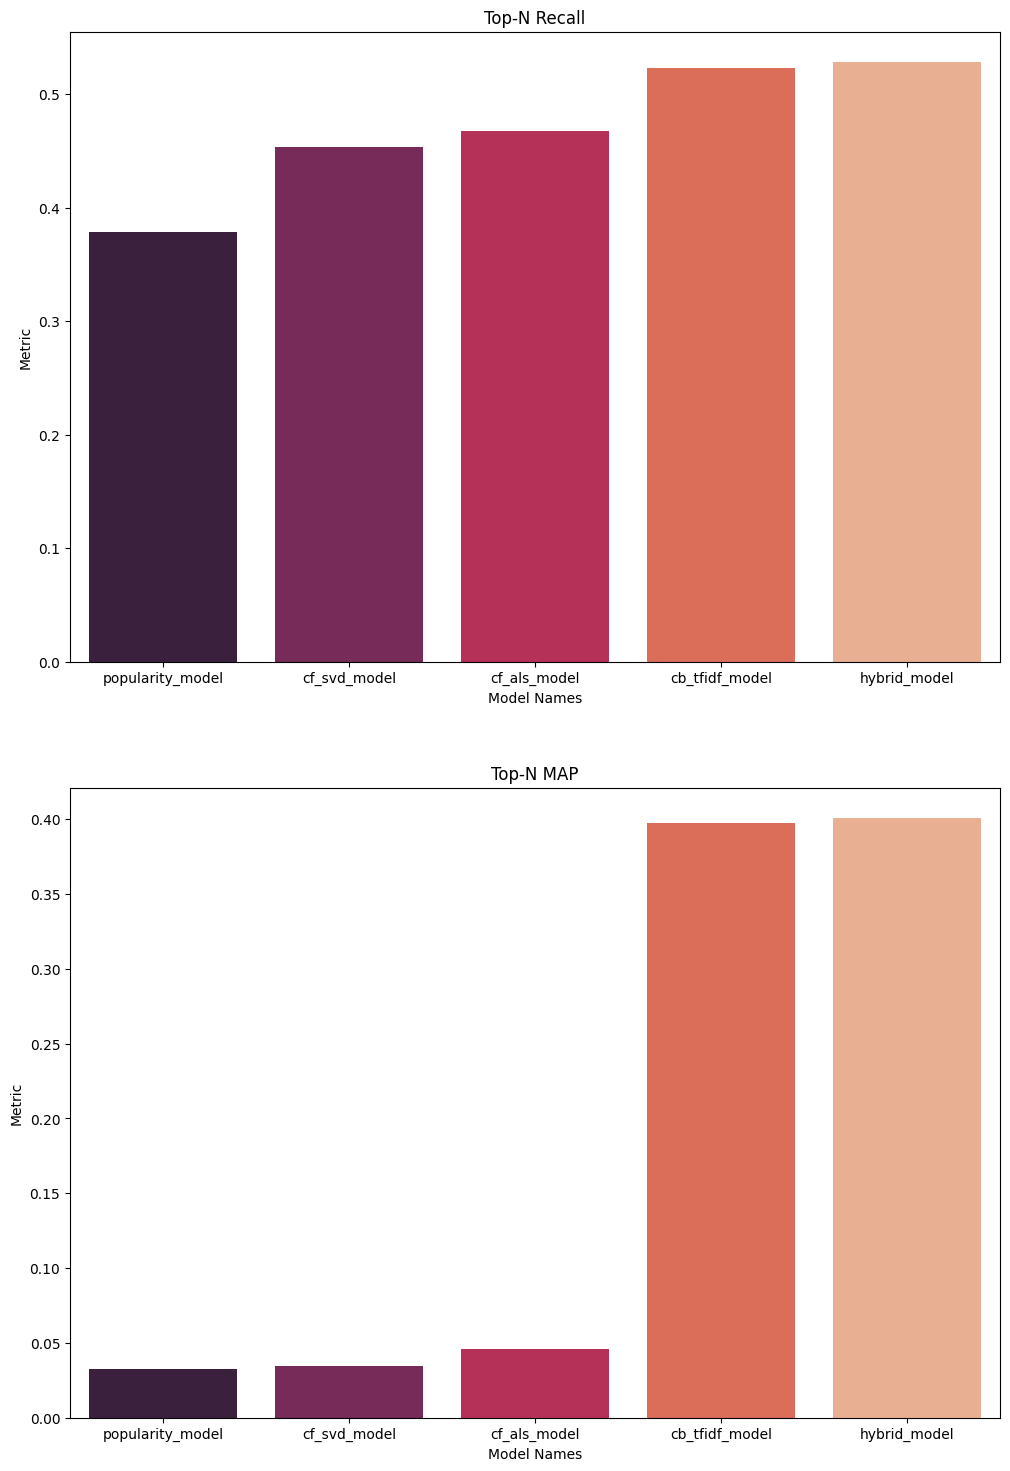

In [214]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 18))

sns.barplot(all_metrics['recall@k'], ax=ax1, palette='rocket')
ax1.set_title('Top-N Recall')
ax1.set_xlabel('Model Names')
ax1.set_ylabel('Metric')

sns.barplot(all_metrics['MAP@k'], ax=ax2, palette='rocket')
ax2.set_title('Top-N MAP')
ax2.set_xlabel('Model Names')
ax2.set_ylabel('Metric')

plt.show()

К датасету применены 4 вида рекоммендательных систем:

* Popularity

* Collaborative Filtering (SVD, ALS)

* Content-Based Filtering (TF-IDF)

* Hybrid

Наилучший результат по Recall@10 и MAP@1O у гибридной модели.